# Imports

In [1]:
import numpy as np
from SEDer import band_retrieval_routines as brr
from SEDer import sed_routines as sr
from SEDer import extinction_routines as er
from astropy.table import Table
from astropy import units as u
from os import path

# Read models

In [2]:
kurucz = Table(np.genfromtxt(path.join('../SEDer', 'models', 'kurucz_sed.dat'), names=True, dtype=None))
co_da  = Table(np.genfromtxt(path.join('../SEDer', 'models', 'CO_DA.dat'), names=True, dtype=None))
co_db  = Table(np.genfromtxt(path.join('../SEDer', 'models', 'CO_DB.dat'), names=True, dtype=None))
he_da  = Table(np.genfromtxt(path.join('../SEDer', 'models', 'He_wd.dat'), names=True, dtype=None))
one_da = Table(np.genfromtxt(path.join('../SEDer', 'models', 'ONe_DA.dat'), names=True, dtype=None))
one_db = Table(np.genfromtxt(path.join('../SEDer', 'models', 'ONe_DB.dat'), names=True, dtype=None))

# Get observed photometry for a Gaia source

In [11]:
obs,flags = brr.get_photometry_single_source(183325907326150528, snr_lim=10)

# SED models

In [8]:
ms = sr.get_MS_sed(teff=5900, m1=1 , r1=1, meta=0, parallax=1.1538)
wd = sr.get_wd_bedard_sed(teff=10000, m=0.3, parallax=1.1538, core='He',atm='H')

# SED fitting

In [9]:
# Gaia source to fit
source_id = 183325907326150528

# Fixed parameters for fit; should be determined from prior knowledge
m1 = 1
meta = 0
av = er.query_extinction(source_id)

teff,teff_err,radius,radius_err,chi2 = sr.fit_MS_RT(source_id=source_id, m1=m1, meta=meta, av=av, parallax=None,
                                                    init_guess=[6000,1],bounds=[(3500,0.5),(10000,10)],bands_to_ignore=[])

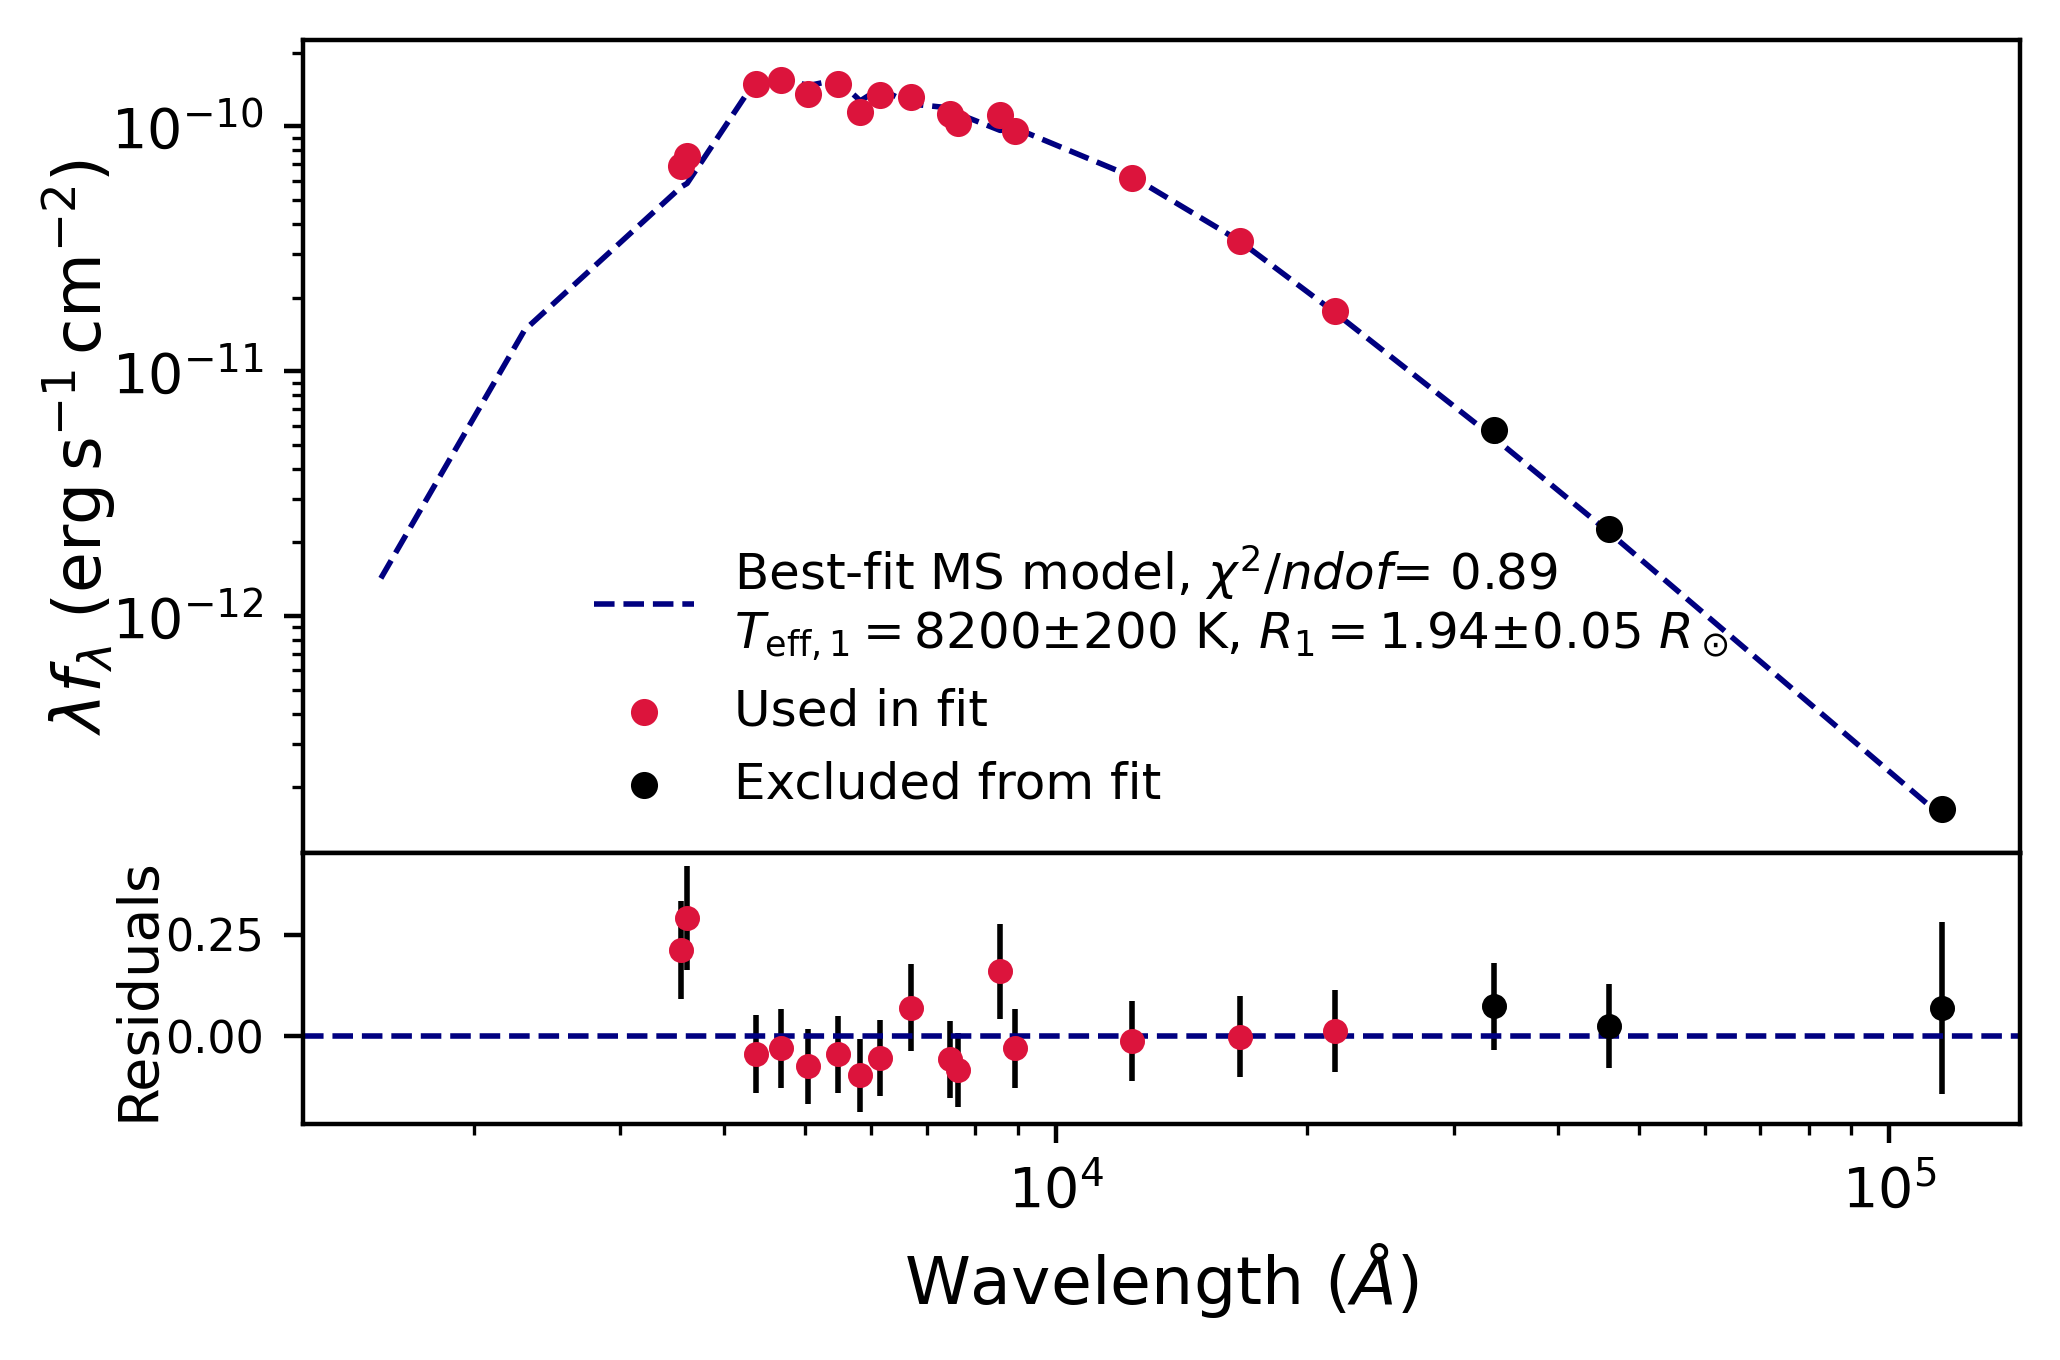

In [ ]:
## Plot SED and best fit
from SEDer import plotting_routines as pr

fit_results = (teff,teff_err,radius,radius_err,chi2)
pr.plot_kurucz_fit(obs, m1, meta, av, fit_results, 
                   source_id=None, parallax=None, bands_to_ignore=['WISE.W1','WISE.W2','WISE.W3'],
                   plot=True, save=False)

# Applying extinction to model flux OR color-magnitude
* Typically, the extinction is given in the Johnson V-band: $A_V$.
* One commonly needs the extinction in some other band X.
* The script extinction_routines.py does this conversion, through the so-called "extinction coefficients" $k_X = A_V/A_X$.
* $k_X$ depends on both $A_V$ AND the temperature of the source (approximation).
* The functions of extinction_routines.py accept $A_V$ and EITHER $T_{eff}$ OR the BP-RP color of the source (used to approximate the temperature).
* For extinction $A_X$, the model flux in the X band should be suppressed by the following factor:
$$F_X' = F_X \cdot 10^{-0.4\cdot A_X}$$
* Similarly, for extinction $A_X$ the model magnitude should be suppressed as follows:
$$X' = X + A_X $$
* For reddening $E(Y-Z)$ the model color changes as follows:
$$(Y-Z)' = (Y-Z) + E(Y-Z)$$

In [ ]:
## Example of reddening model flux

teff_model = 5900 # temperature of model is known exactly, and determines the extinction coefficients
Gflux = sr.get_MS_sed(teff=teff_model, m1=1 , r1=1, meta=0, parallax=1.1538)['G3'] # G-band flux in physical units
Av = 0.1 # Assume some extinction in V-band; this could be provided by extinction maps or other sources
A_G,A_BP,A_RP = er.get_Gaia_extinction(Av,0,teff_model) # Get extinction coefficients for the model temperature

Gflux_reddened = Gflux * 10**(-0.4*A_G) # Apply extinction to the G-band flux
print(f'Model flux: {Gflux[0]*Gflux.unit:.2e}')
print(f'Reddened flux: {Gflux_reddened[0]*Gflux.unit:.2e}')

In [ ]:
## Example of reddening model color+magnitude

Gmag = 10 # Assume some G-band magnitude (given by some model)
bprp_color = 1 # Assume some BP-RP color (given by some model)
Av = 0.5

A_G, E_BPRP = er.get_AG_EBPRP(Av,bprp_color) 

Gmag_reddened = Gmag + A_G
bprp_color_reddened = bprp_color + E_BPRP
print(f'Model G: {Gmag:.2f}')
print(f'Reddened G: {Gmag_reddened:.2f}')
print(f'Model BP-RP: {bprp_color:.2f}')
print(f'Reddened BP-RP: {bprp_color_reddened:.2f}')